In [1]:
# import time
# from copy import deepcopy, copy
# import math
# import scipy.io as sio
# from random import shuffle
# import numpy as np
# from pylab import *
# # from featext2 import *
# import matplotlib.pyplot as plt
# %matplotlib inline 
# #matplotlib qt
# # inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
# from matplotlib.colors import ListedColormap
# from mpl_toolkits.mplot3d import Axes3D #, axes3d
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
# from sklearn.metrics import classification_report, confusion_matrix
# from collections import OrderedDict
import time
start_time = time.time()
from copy import deepcopy, copy
import math
import scipy.io as sio
import shutil
import os
from random import shuffle
import numpy as np
from pylab import *
# from featext2 import *
import matplotlib.pyplot as plt
%matplotlib inline 
#matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D #, axes3d
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, ParameterGrid, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RandomizedLasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif, SelectFdr
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import OrderedDict
import re
import datetime
import urllib
import tarfile
# import joblib
# from joblib import Parallel, delayed, Memory
from tempfile import mkdtemp
import copy_reg
import types
import itertools
from itertools import compress
from collections import Counter


In [2]:
def make_pipe_clf(scaler,feature_selection,decomp,clf):
    order = 1
# order = 1 : first perform feature selection and then apply PCA
# order = 0 : first apply PCA and then reduce the transformed features
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                    ('classifier', clf) ])
#     else:
#         pipeline = Pipeline([('scaler', scaler),
#                     ('decomp', decomp ),                 
#                     ('feature_selection', feature_selection),        
#                     ('classifier', clf) ])
    return pipeline
###########################################################################################
def make_pipe(scaler,feature_selection,decomp,order):
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                     ])
    else:
        pipeline = Pipeline([('scaler', scaler),
                    ('decomp', decomp ),                 
                    ('feature_selection', feature_selection),        
                     ])
    return pipeline

In [3]:
filename = 'tmp/features/1024_20/newfeatures_testdata_NOsample_trans_1024_20_10_10000_XYsplit.npz'
Xsp = np.load(filename)['Xsp']
Ysp = np.load(filename)['Ysp']

In [4]:
print([ Xsp[i][j].shape for i in range(len(Xsp)) for j in range(len(Xsp[i]))])

[(8514, 3107), (8514, 3107), (8514, 6214), (8514, 3107), (8514, 3107), (8514, 6214), (8276, 3107), (8276, 3107), (8276, 6214)]


In [5]:
X_new = {}
for i in range(Xsp.shape[1]):
    X_new[i] = np.concatenate((Xsp[0][i][::2,:],Xsp[1][i][::2,:]),axis=0)
X_new = [i for _,i in X_new.items()]
#X_new = np.array(X_new)
#print X_new.shape
for i in range(len(X_new)):
    print X_new[i].shape


(8514, 3107)
(8514, 3107)
(8514, 6214)


In [6]:
Y_new = np.concatenate((Ysp[0][::2],Ysp[1][::2]),axis=0)
print Y_new.shape

(8514,)


In [7]:
# splitting dataset from both fingers into each surface 
fs = 1
data_X = deepcopy(X_new[fs]) ; data_Y = deepcopy(Y_new)
surfaces_pre = np.split(data_X,6)
surf_labels_pre = np.split(data_Y,6)
surfaces = [np.empty_like(surfaces_pre[i]) for i in range(3)]
surf_labels = [np.empty_like(surf_labels_pre[i]) for i in range(3)]

for i in range(3):
    inds = range(i,6,3)
    surfaces[inds[0]] = np.concatenate((surfaces_pre[inds[0]], surfaces_pre[inds[1]]), axis = 0)
    surf_labels[inds[0]] = np.concatenate((surf_labels_pre[inds[0]], surf_labels_pre[inds[1]]), axis = 0)

In [32]:
# Training the classifiers for the real time validation 
classifiers = [
    KNeighborsClassifier(5),
    SVC(gamma='auto', C=1),
    MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
]
datapath = 'tmp/trained_pipes_1b1/'
scaler = StandardScaler() ; featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
decomp = PCA(n_components=20)
pipe_list = [make_pipe_clf(scaler,featsel, decomp, classifiers[i]) for i in range(len(classifiers))]
filename2 = 'overall_models'
# models = []
for surf in range(len(surfaces)):
    print(surf)
    train_x = surfaces[surf]
    for pipe_id, pipe in enumerate(pipe_list):
        filename = 'surf'+'_'+str(surf)+'_'+str(pipe_id)
        print(pipe_id)
        pipefile = datapath+filename+'.npz'
        print("Started fitting...")
        model = pipe.fit(train_x, surf_labels[surf])
#         models.append(model)
        print("...done fitting")
        np.savez(pipefile,model=np.array([model]))

0
0
Started fitting...
...done fitting
1
Started fitting...
...done fitting
2
Started fitting...
...done fitting
3
Started fitting...
...done fitting
1
0
Started fitting...
...done fitting
1
Started fitting...
...done fitting
2
Started fitting...
...done fitting
3
Started fitting...
...done fitting
2
0
Started fitting...
...done fitting
1
Started fitting...
...done fitting
2
Started fitting...
...done fitting
3
Started fitting...
...done fitting


0.976196230063


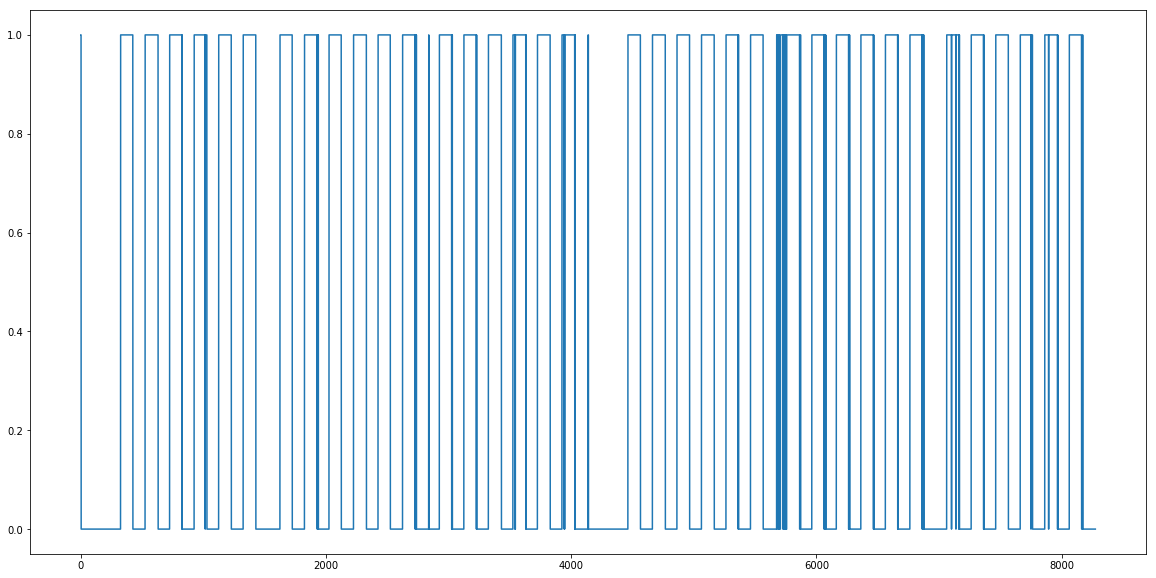

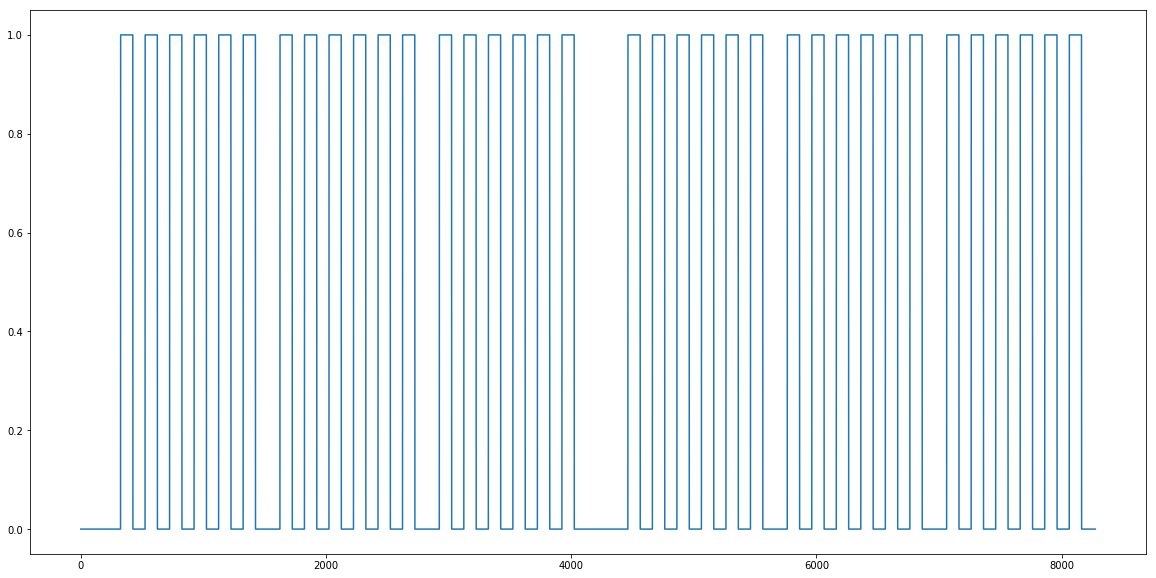

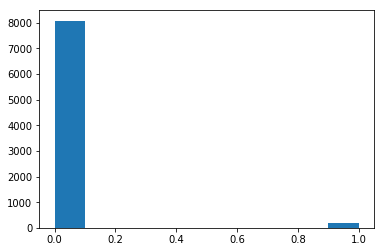

In [16]:
temp = np.load('tmp/trained_pipes2/fs_2_2.npz')
fing = 2; fs = 2 
clf = temp['model']
# clf2 = np.array([gamhmene['model']])
# feat = list(clf[0].named_steps['feature_selection'].get_support(indices = True))
x_data = Xsp[fing][fs] ; true_labels = Ysp[fing]
predicted = clf[0].predict(x_data)
plt.figure(0,figsize=(20,10))
plt.plot(predicted)
# plt.hold
plt.figure(1, figsize=(20,10))
plt.plot(true_labels)
plt.figure(2)
plt.hist(np.abs(true_labels-predicted))
print(clf[0].score(x_data,true_labels))

0.730787820203


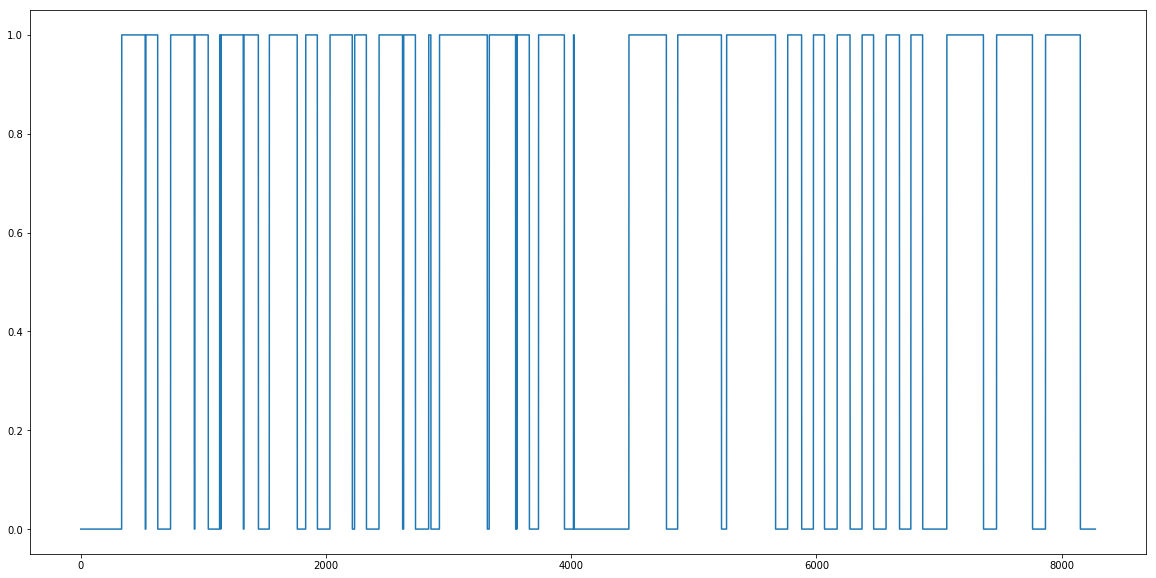

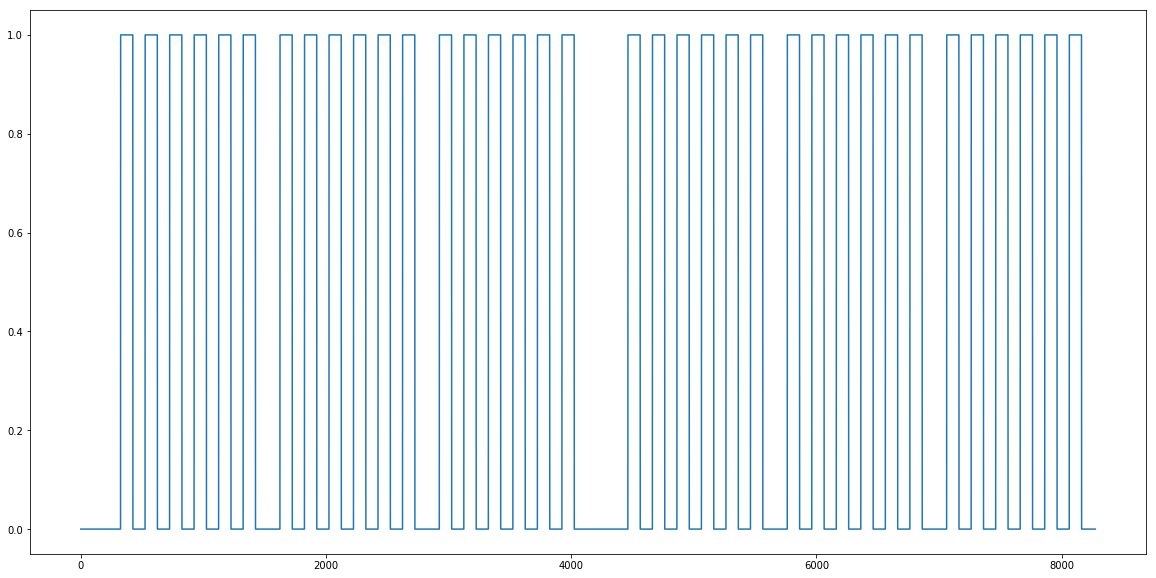

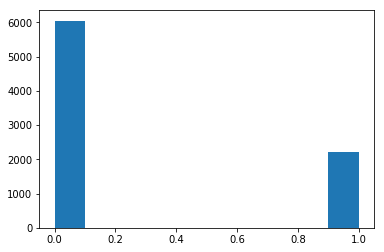

In [13]:
temp = np.load('tmp/trained_pipes_1b1/surf_0_2.npz')
fing = 2; fs = 1 
clf = temp['model']
# clf2 = np.array([gamhmene['model']])
# feat = list(clf[0].named_steps['feature_selection'].get_support(indices = True))
x_data = Xsp[fing][fs] ; true_labels = Ysp[fing]
predicted = clf[0].predict(x_data)
plt.figure(0,figsize=(20,10))
plt.plot(predicted)
# plt.hold
plt.figure(1, figsize=(20,10))
plt.plot(true_labels)
plt.figure(2)
plt.hist(np.abs(true_labels-predicted))
print(clf[0].score(x_data,true_labels))